# Análisis de los retornos anuales del índice NASDAQ (IXIC) mediante Gráficos de Control Estacionario de Schewhart

Se presenta a continuación, un análisis de las tasas de retorno del índice NASDAQ (IXIC) desde 1971 hasta la actualidad, utilizando 

- Gráfico de Control Estacionario
- Identificación de causas especiales
- Comportamiento en períodos de crisis
- Predicción

## Gráfico de Control Estacionario


In [26]:
from IPython.display import Markdown as md
import pandas as pd
import requests as req
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

timestamp = int(datetime.timestamp(datetime.now()))
download_url = "https://query1.finance.yahoo.com/v7/finance/download/%5EIXIC?period1=34560000&period2={}&interval=1mo&events=history".format(timestamp)
#download_url = "https://query1.finance.yahoo.com/v7/finance/download/%5EGSPC?period1=34560000&period2={}&interval=1mo&events=history".format(timestamp)
r = req.get(download_url, allow_redirects=True)
open('historical_data.csv', 'wb').write(r.content)

historical_data = pd.read_csv("historical_data.csv")
historical_data = historical_data[pd.to_datetime(historical_data['Date']).dt.month == 1]
historical_data.set_index('Date', inplace=True)

adj_close_year = historical_data['Adj Close']
rt = 100 * np.log(adj_close_year / adj_close_year.shift(1))
rm = np.abs(rt - rt.shift(1))

average_rt = rt.mean()
average_rm = rm.mean()
sigma = 2.66 * average_rm / 3 
regions = np.arange(3,-4,-1) * sigma + average_rt

md("Media : {:0.2f}<br>\
    Media rango móvil : {:0.2f}<br>\
    Sigma : {:0.2f}<br>".format(average_rt, average_rm, sigma))

Media : 9.05<br>    Media rango móvil : 21.61<br>    Sigma : 19.16<br>

(<AxesSubplot:xlabel='Date'>,
 array([1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
        1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
        1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
        2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
        2016, 2017, 2018, 2019, 2020]))

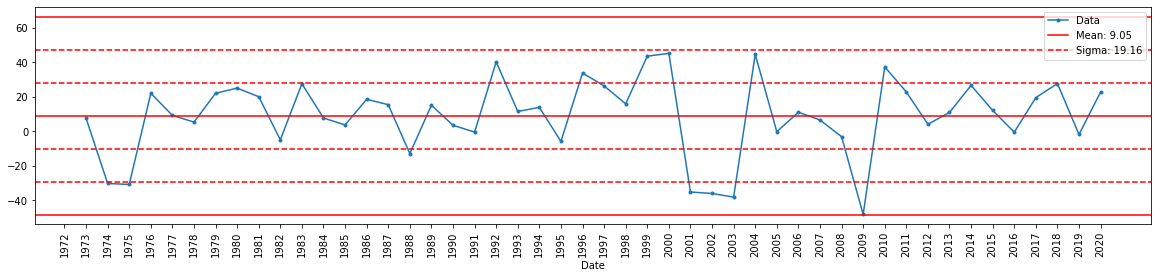

In [27]:
def fullplot(indata, inregions):
    plt.rcParams['figure.figsize'] = [20, 4]

    xticks = np.array(pd.to_datetime(indata.index).year.to_list())

    my_plot = indata.plot(style='.-', label="Data")
    plt.xticks(np.arange(indata.shape[0])[::1], xticks[::1], rotation=90)

    plt.axhline(y=inregions[0], color='r', linestyle='-')
    plt.axhline(y=inregions[1], color='r', linestyle='--')
    plt.axhline(y=inregions[2], color='r', linestyle='--')
    plt.axhline(y=inregions[3], color='r', linestyle='-', label="Mean: " + str(round(inregions[3],2)))
    plt.axhline(y=inregions[4], color='r', linestyle='--', label="Sigma: " + str(round(inregions[3] - inregions[4],2)))
    plt.axhline(y=inregions[5], color='r', linestyle='--')
    plt.axhline(y=inregions[6], color='r', linestyle='-')
    plt.legend(loc='upper right')

    return my_plot, xticks

fullplot(rt, regions)

## Identificación de Causas Especiales

Sobre esta misma gráfica, se procede a identificar los periodos afectados por causas especiales, y se resaltarán en verde en la siguiente figura:

In [28]:
def find_condition(data, window_size, condition, min_number=None):
    _min_number = window_size if min_number is None else min_number
    finds = []
    for i in range(len(data) - window_size + 1):
        if i in finds:
            pass

        count = sum(map(condition, data[i:i+window_size]))        
        if count >= _min_number:
            finds.append(list(range(i, i+window_size)))
    return finds

def strictly_increasing(L):
    return all(x <= y for x, y in zip(L, L[1:]))

def strictly_decreasing(L):
    return all(x >= y for x, y in zip(L, L[1:]))

def trend(L):
    return strictly_decreasing(L) or strictly_increasing(L)

def find_trend(data, window_size):    
    finds = []
    for i in range(len(data) - window_size + 1):   
        if i in finds:
            pass        
        if trend(data[i:i+window_size]):
            finds.append(list(range(i, i+window_size)))
    return finds

def wave(L):    
    even = L[0] > L[1]
    for x, y in zip(L, L[1:]):
        if even:
            if x < y:
                return False
        else:
            if x > y:
                return False    
        even = not even
    return True

def find_wave(data, window_size):    
    finds = []
    for i in range(len(data) - window_size + 1):     
        if i in finds:
            pass      
        if wave(data[i:i+window_size]):
            finds.append(list(range(i, i+window_size)))
    return finds

def signals(indata, verbose=False, iterative=False):
    signals = []
    # 1) Outside limits
    signal_1 = find_condition(indata, 1, lambda x: x >= regions[0]  or regions[6] >= x)
    if verbose: print("Signal 1: ", signal_1)
    for s in signal_1:
        signals.append(s)     

    # 2) 2 out of 3 points in region A
    signal_2 = find_condition(indata, 2, lambda x:  regions[0] >= x >= regions[1]  or regions[5] >= x >= regions[6] , 2)
    if verbose: print("Signal 2: ", signal_2)
    for s in signal_2:
        signals.append(s)     

    # 3) 4 out of 5 points in region A and/or B
    signal_3 = find_condition(indata, 4, lambda x: regions[0] >= x >= regions[2]  or regions[4] >= x >= regions[6], 4)
    if verbose: print("Signal 3: ", signal_3)
    for s in signal_3:
        signals.append(s)     

    # 4) 9 consecutive points on one side of central axis
    signal_4 = find_condition(indata, 9, lambda x: x > regions[3] ) + find_condition(rt, 9, lambda x: x < regions[3])
    if verbose: print("Signal 4: ", signal_4)
    for s in signal_4:
        signals.append(s)     

    # 5) 6 consecutive points increasing/decreasing only
    signal_5 = find_trend(indata, 6)
    if verbose: print("Signal 5: ", signal_5)
    for s in signal_5:
        signals.append(s) 

    # 6) 14 consecutive points in oscilation
    signal_6 = find_wave(indata, 14)
    if verbose: print("Signal 6: ", signal_6)
    for s in signal_6:
        signals.append(s) 

    # 7) 15 consecutive points in region C
    signal_7 = find_condition(indata, 15, lambda x: regions[2] > x > regions[4] )
    if verbose: print("Signal 7: ", signal_7)
    for s in signal_7:
        signals.append(s) 

    return signals


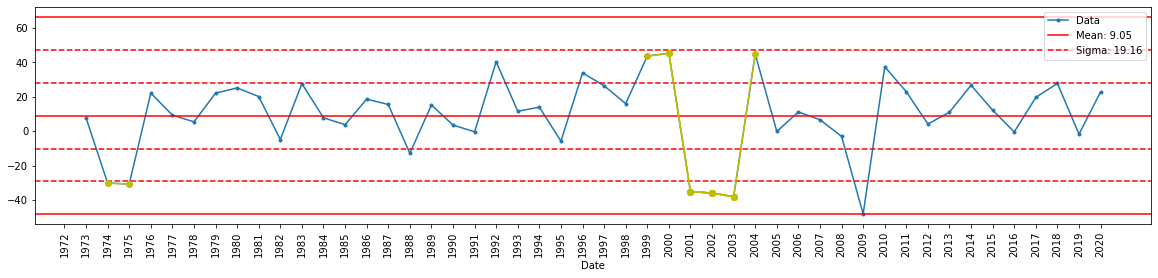

In [29]:
mplt, xticks = fullplot(rt, regions)

for signal in signals(rt):    
    mplt.plot(signal, rt[signal], '-o',color='y')


Así pues, se observa que los periodos afectados por causas especiales son:

-  1974-1975, que se relaciona con la crisis del petróleo de 1973
-  1999-2004, que se relaciona con la burbuja de las Dot-com entre 1997 y 2000

Se procede ahora a realizar el cálculo del gráfico de control estacionario, pero esta vez eliminando de los datos estos periodos señalados.

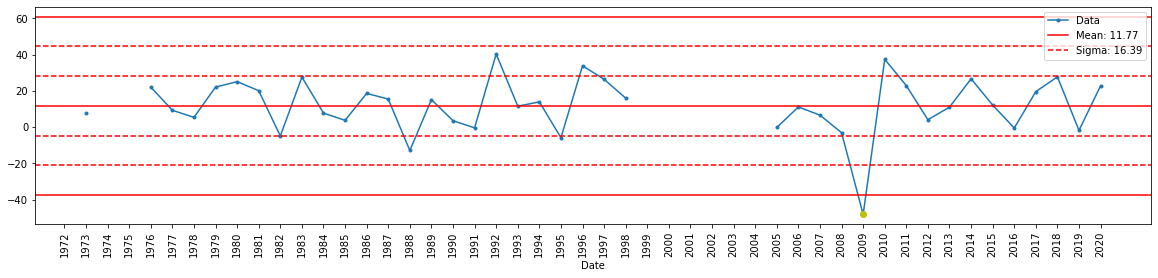

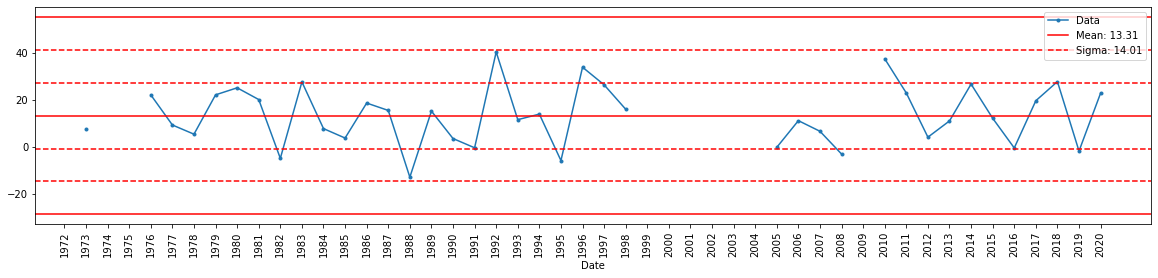

In [30]:
special_signal = True

special_cause = []

tmp_rt = rt.copy()
tmp_rm = rm.copy()

count = 0
while special_signal:
    all_signal = set([])
    for signal in signals(tmp_rt):
        all_signal.update(set(signal))

    dropable = sorted(list(all_signal))

    for d in dropable:
        special_cause.append(d)
        tmp_rt[d] = None
        tmp_rm[d] = None
        if len(tmp_rm) > d + 1: 
            tmp_rm[d+1] = None

    average_rt = tmp_rt.mean()
    average_rm = tmp_rm.mean()
    sigma = 2.66 * average_rm / 3
    regions = np.arange(3,-4,-1) * sigma + average_rt

    figure, axes = plt.subplots(1, 1)
    mplt, xticks = fullplot(tmp_rt, regions)

    special_signal = False   
    for signal in signals(tmp_rt):
        mplt.plot(signal, tmp_rt[signal], '-o',color='y')
        special_signal = True

    count += 1
    if(count == 10): break

De esta manera, al reajustar los valores de la estimación de la media y de sigma, se identifica una nueva causa especial en 2009, que estaría relacionada con la crisis sub-prime de 2008.

Si eliminamos esta causa especial nuevamente, los valores son:

In [ ]:
md("Media : {:0.2f}<br>\
    Media rango móvil : {:0.2f}<br>\
    Sigma : {:0.2f}<br>".format(average_rt, average_rm, sigma))

Mean: -36.406102405220174
Mean moving-range: 15.804087114686965
Sigma: 3.1849775399373748
Regions: [-26.85116979 -30.03614733 -33.22112487 -36.40610241 -39.59107995
 -42.77605749 -45.96103503]


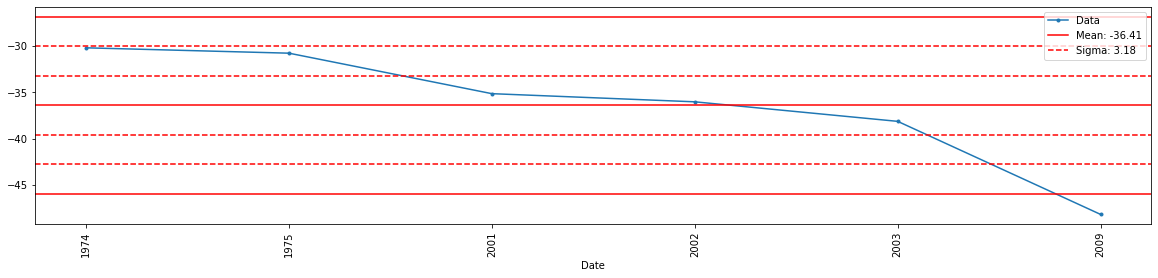

In [32]:
_sc = rt[special_cause]
sc = _sc[_sc < 0]

rm_sc = np.abs(sc - sc.shift(1))

average_sc = sc.mean()
print("Mean:", average_sc)

average_rm_sc = rm_sc.mean()
print("Mean moving-range:", average_rm)

sigma_sc = 2.66 * average_rm_sc / 3 
print("Sigma:", sigma_sc)

regions_sc = np.arange(3,-4,-1) * sigma_sc + average_sc
print("Regions:", regions_sc)

figure, axes = plt.subplots(1, 1)
mplt, xticks = fullplot(sc, regions_sc)

In [33]:
print(len(tmp_rm))
print(d)

49
37
